## Question 4: Quantization
Please also consult the HW PDF to know the specific things you need to do.

## Initial Setup

Before beginning the assignment, we import the CIFAR dataset, and train a simple convolutional neural network (CNN) to classify it.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

**Reminder:** set the runtime type to "GPU", or your code will run much more slowly on a CPU.

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Load training and test data from the CIFAR10 dataset.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 40.2MB/s]


Define a simple CNN that classifies CIFAR images.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

Train this CNN on the training dataset (this may take a few moments).

In [5]:
from torch.utils.data import DataLoader

def train(model: nn.Module, dataloader: DataLoader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(2):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break

    return 100 * correct / total

In [6]:
train(net, trainloader)

[1,  2000] loss: 2.209
[1,  4000] loss: 1.868
[1,  6000] loss: 1.708
[1,  8000] loss: 1.607
[1, 10000] loss: 1.555
[1, 12000] loss: 1.489
[2,  2000] loss: 1.425
[2,  4000] loss: 1.423
[2,  6000] loss: 1.369
[2,  8000] loss: 1.349
[2, 10000] loss: 1.328
[2, 12000] loss: 1.334
Finished Training


Now that the CNN has been trained, let's test it on our test dataset.

In [7]:
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 53.4%


In [8]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

## Question 1: Visualize Weights

In [9]:
import matplotlib.pyplot as plt
import numpy as np

1. Weight Distribution Analysis
- Plot histogram of weights for each layer
- Calculate statistical measures (range, mean, std)
- Analyze distribution patterns across layers

In [10]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (fc1): Linear(in_features=400, out_features=120, bias=False)
  (fc2): Linear(in_features=120, out_features=84, bias=False)
  (fc3): Linear(in_features=84, out_features=10, bias=False)
)

In [11]:
# ADD YOUR CODE HERE to plot distributions of weights

# You can get a flattened vector of the weights of fc1 like this:
#   fc1_weights = net.fc1.weight.data.cpu().view(-1)
# Try plotting a histogram of fc1_weights (and the weights of all the other layers as well)

import math
from collections import OrderedDict

def iter_weight_layers_for_net(net):
    for name in ["conv1", "conv2", "fc1", "fc2", "fc3"]:
        m = getattr(net, name, None)
        if m is not None and hasattr(m, "weight") and m.weight is not None:
            yield name, m

def weight_stats(w: torch.Tensor):
    w = w.detach().float().cpu().view(-1)
    return OrderedDict([
        ("min", w.min().item()),
        ("max", w.max().item()),
        ("range", (w.max()-w.min()).item()),
        ("mean", w.mean().item()),
        ("std",  w.std(unbiased=False).item()),
        ("absmax", w.abs().max().item()),
        ("sparsity", (w==0).float().mean().item()),
    ])

def plot_weight_histograms_for_net(net, bins=80):
    net.eval()
    for idx, (name, layer) in enumerate(iter_weight_layers_for_net(net), 1):
        w = layer.weight.detach().cpu().view(-1)
        stats = weight_stats(layer.weight)
        plt.figure(figsize=(6,4))
        plt.hist(w.numpy(), bins=bins, edgecolor="black")
        plt.title(f"[{idx}] {name} ({layer.__class__.__name__})")
        plt.xlabel("Weight value"); plt.ylabel("Frequency")
        plt.grid(True, alpha=0.3)
        txt = f"mean={stats['mean']:.3g}, std={stats['std']:.3g}, absmax={stats['absmax']:.3g}"
        plt.suptitle(txt, y=0.98, fontsize=9)
        plt.tight_layout()
        plt.show()

        print(f"== {name} ({layer.__class__.__name__}) stats ==")
        for k,v in stats.items():
            print(f"{k:>9}: {v:.6f}")
        print()

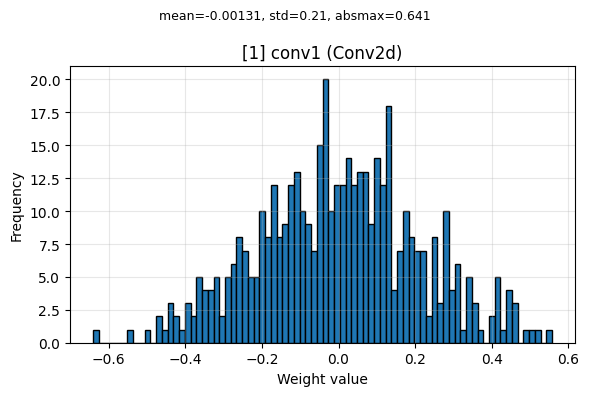

== conv1 (Conv2d) stats ==
      min: -0.640619
      max: 0.557296
    range: 1.197914
     mean: -0.001310
      std: 0.210235
   absmax: 0.640619
 sparsity: 0.000000



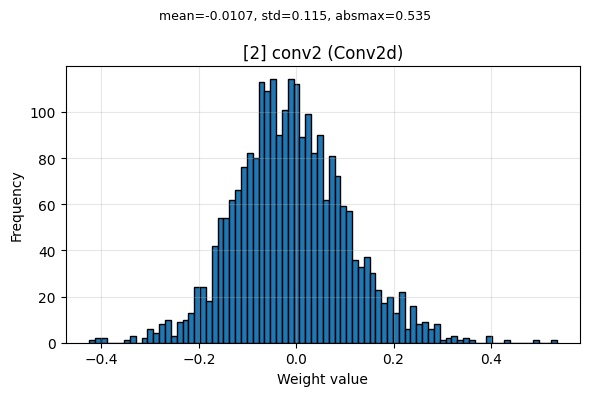

== conv2 (Conv2d) stats ==
      min: -0.425602
      max: 0.535037
    range: 0.960639
     mean: -0.010711
      std: 0.114738
   absmax: 0.535037
 sparsity: 0.000000



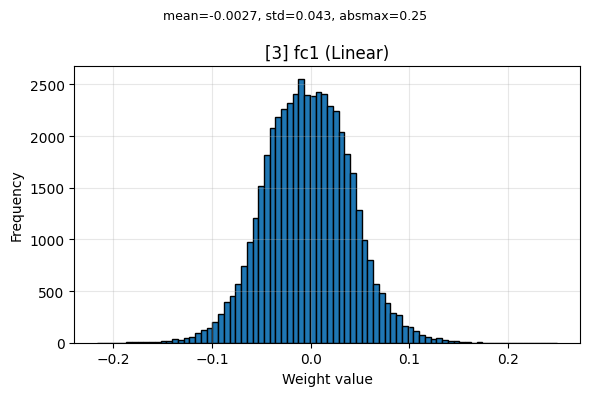

== fc1 (Linear) stats ==
      min: -0.216260
      max: 0.249890
    range: 0.466150
     mean: -0.002699
      std: 0.042977
   absmax: 0.249890
 sparsity: 0.000000



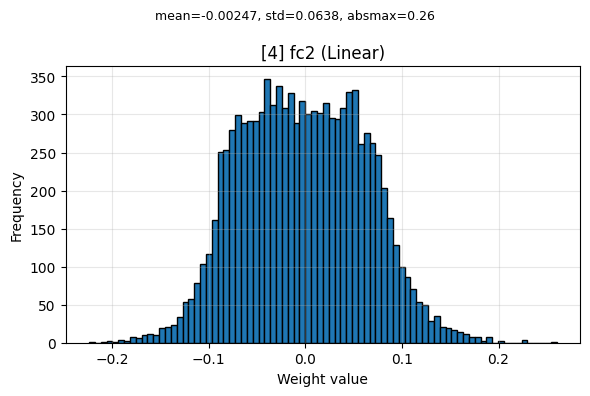

== fc2 (Linear) stats ==
      min: -0.224071
      max: 0.260166
    range: 0.484237
     mean: -0.002470
      std: 0.063813
   absmax: 0.260166
 sparsity: 0.000000



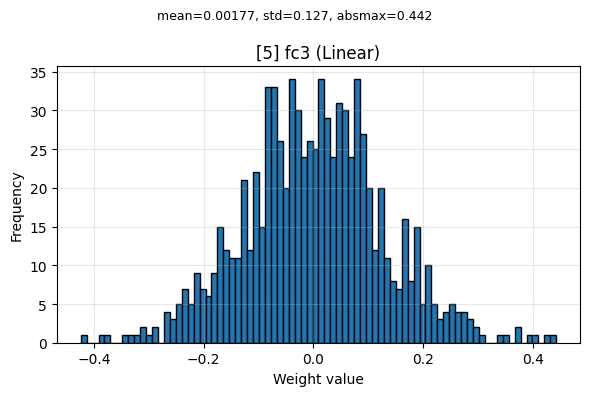

== fc3 (Linear) stats ==
      min: -0.423922
      max: 0.442455
    range: 0.866377
     mean: 0.001767
      std: 0.127426
   absmax: 0.442455
 sparsity: 0.000000



In [12]:
net.eval()
plot_weight_histograms_for_net(net)

### Weight distribution analysis

All layers show weight distributions centered near zero and roughly Gaussian. The convolutional layers (conv1, conv2) have broader, heavier tails (absmax = 0.64 and 0.54), while the middle fully connected layers (fc1, fc2) are narrower (absmax = 0.25 and 0.26) due to normalization and pooling. The final layer (fc3) widens again (absmax = 0.44) as larger weights are needed for class separation.

Most layers are nearly symmetric with means close to zero, supporting the use of symmetric quantization (zero-point = 0). However, the heavy-tailed layers may require per-channel or percentile-based scaling to reduce rounding errors. All layers have 0% sparsity, indicating pruning has little effect.

In summary, symmetric quantization is suitable overall, but convolutional and output layers demand finer scaling to preserve accuracy.

## Question 2: Quantize Weights

In [13]:
net_q2 = copy_model(net)

In [14]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''
    # ADD YOUR CODE HERE

    # 1. tensor is detached + CPU
    w = weights.detach().cpu().float()

    # 2. Implement scaling strategy for optimal accuracy
    max_abs = w.abs().max().item()
    if max_abs == 0 or not torch.isfinite(torch.tensor(max_abs)):
        scale = 1.0
    else:
        scale = 127.0 / max_abs
    # apply scaling, rounding, climping
    q = torch.round(w * scale)
    q = torch.clamp(q, min=-128, max=127)

    # 4. Validation: confirm quantized values are in int8 range
    assert q.min() >= -128 and q.max() <= 127, "Quantized weights exceed int8 range!"

    return q, scale

In [15]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

In [16]:
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights: {}%'.format(score))

Accuracy of the network after quantizing all weights: 53.39%


### Quantization strategy explanation
Weights were quantized using symmetric per-layer INT8 scaling, where each layer’s weights were multiplied by a single scale factor s=127/max(|w|). This ensures that the largest absolute weight value maps exactly to the INT8 boundary [-128, 127], maximizing dynamic range without introducing bias. The quantized weights were then rounded and clamped to remain within valid bounds.
This simple linear mapping preserves the near-zero Gaussian distribution of weights observed earlier, maintaining balance between precision and compression efficiency.

### Impact on Model Accuracy
After quantizing all weights, the model achieved 53.39% accuracy, nearly identical to the baseline (53.4%). This indicates that the symmetric scaling effectively preserved weight variance and sign symmetry, minimizing quantization-induced distortion.

## Question 3: Visualize Activations

In [17]:
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)
    model.fc2.activations = np.empty(0)
    model.fc3.activations = np.empty(0)

    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().view(-1))
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().view(-1))
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().view(-1))
    model.fc1.register_forward_hook(fc1_activations_hook)

    def fc2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc1.activations = np.append(model.fc1.activations, x[0].cpu().view(-1))
    model.fc2.register_forward_hook(fc2_activations_hook)

    def fc3_activations_hook(layer, x, y):
        if model.profile_activations:
            model.fc2.activations = np.append(model.fc2.activations, x[0].cpu().view(-1))
            model.fc3.activations = np.append(model.fc3.activations, y[0].cpu().view(-1))
    model.fc3.register_forward_hook(fc3_activations_hook)


In [18]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400)
net_q3.profile_activations = False

In [19]:
input_activations = net_q3.input_activations
conv1_output_activations = net_q3.conv1.activations
conv2_output_activations = net_q3.conv2.activations
fc1_output_activations = net_q3.fc1.activations
fc2_output_activations = net_q3.fc2.activations
fc3_output_activations = net_q3.fc3.activations

In [22]:
# ADD YOUR CODE HERE to plot distributions of activations

# Plot histograms of the following variables, and calculate their ranges and 3-sigma ranges:
#   input_activations
#   conv1_output_activations
#   conv2_output_activations
#   fc1_output_activations
#   fc2_output_activations
#   fc3_output_activations

def plot_activation_stats(name, values, bins = 80):
    a = np.asarray(values, dtype=np.float32).ravel()

    mn, mx = float(a.min()), float(a.max())
    mu, sd = float(a.mean()), float(a.std())
    lo, hi = mu - 3.0 * sd, mu + 3.0 * sd
    coverage = float(((a >= lo) & (a <= hi)).mean() * 100.0)

    # histogram
    plt.figure(figsize=(6, 4))
    plt.hist(a, bins=bins, edgecolor="black")
    plt.title(name)
    plt.xlabel("Activation value"); plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)

    # summary
    plt.suptitle(
        f"mean={mu:.4g}, std={sd:.4g} | full=[{mn:.3g},{mx:.3g}] | 3-sigma=[{lo:.3g},{hi:.3g}] | {coverage:.1f}% in",
        y=0.98, fontsize=9
    )
    plt.tight_layout()
    plt.show()

    # detailed printout
    print(f"== {name} stats ==")
    print(f"min : {mn:.6f}")
    print(f"max : {mx:.6f}")
    print(f"range : {(mx - mn):.6f}")
    print(f"mean : {mu:.6f}")
    print(f"std : {sd:.6f}")
    print(f"3-sig : [{lo:.6f}, {hi:.6f}]")
    print(f"in-3sig : {coverage:.2f}% of values\n")

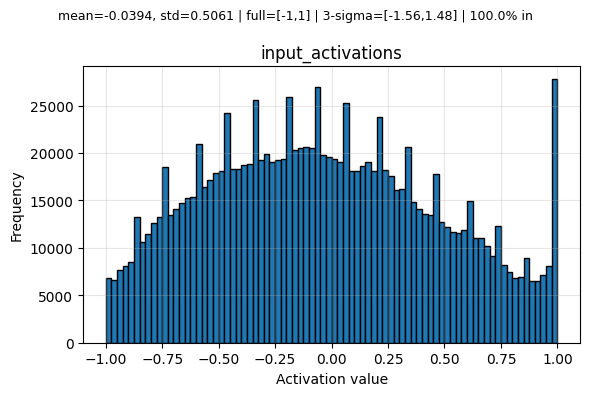

== input_activations stats ==
min : -1.000000
max : 1.000000
range : 2.000000
mean : -0.039399
std : 0.506094
3-sig : [-1.557681, 1.478884]
in-3sig : 100.00% of values



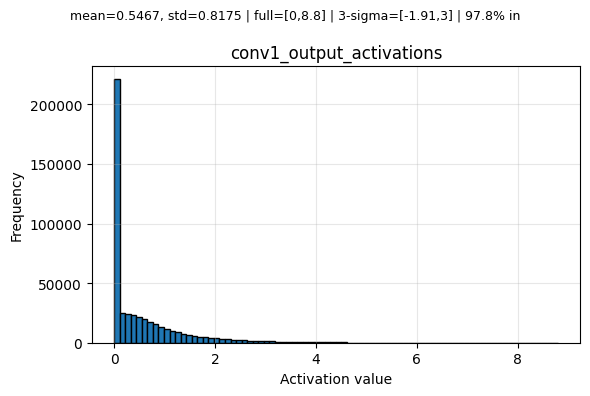

== conv1_output_activations stats ==
min : 0.000000
max : 8.799270
range : 8.799270
mean : 0.546669
std : 0.817549
3-sig : [-1.905978, 2.999316]
in-3sig : 97.77% of values



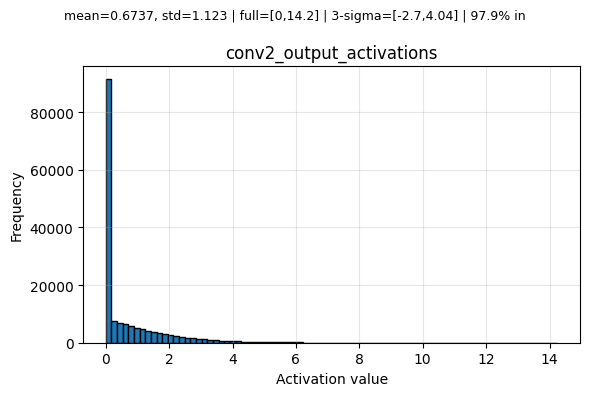

== conv2_output_activations stats ==
min : 0.000000
max : 14.248778
range : 14.248778
mean : 0.673654
std : 1.123374
3-sig : [-2.696467, 4.043776]
in-3sig : 97.87% of values



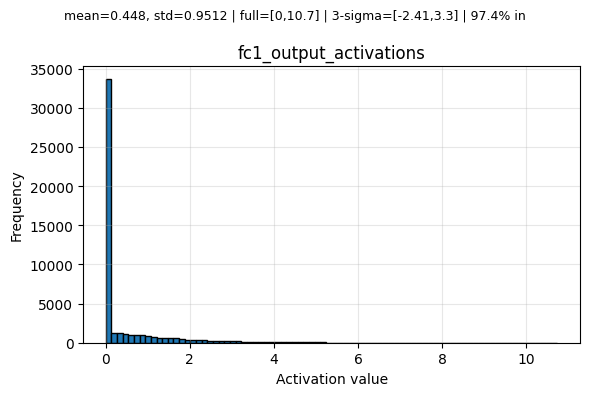

== fc1_output_activations stats ==
min : 0.000000
max : 10.742282
range : 10.742282
mean : 0.447978
std : 0.951222
3-sig : [-2.405687, 3.301642]
in-3sig : 97.40% of values



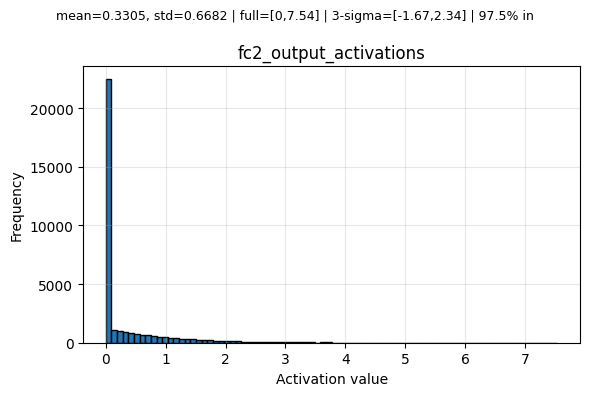

== fc2_output_activations stats ==
min : 0.000000
max : 7.540799
range : 7.540799
mean : 0.330476
std : 0.668204
3-sig : [-1.674137, 2.335088]
in-3sig : 97.52% of values



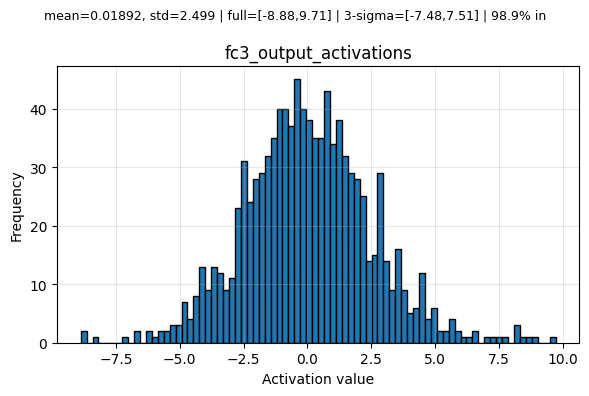

== fc3_output_activations stats ==
min : -8.875631
max : 9.714358
range : 18.589990
mean : 0.018925
std : 2.498587
3-sig : [-7.476835, 7.514685]
in-3sig : 98.91% of values



In [23]:
plot_activation_stats("input_activations", input_activations)
plot_activation_stats("conv1_output_activations", conv1_output_activations)
plot_activation_stats("conv2_output_activations", conv2_output_activations)
plot_activation_stats("fc1_output_activations", fc1_output_activations)
plot_activation_stats("fc2_output_activations", fc2_output_activations)
plot_activation_stats("fc3_output_activations", fc3_output_activations)

### Activation Distribution Analysis

The input activations are symmetric and roughly uniform within [-1, 1], consistent with normalized CIFAR-10 inputs. The early convolution layers (conv1, conv2) show strongly right-skewed, ReLU-shaped distributions, most activations near zero with a few large outliers.
The fully connected layers (fc1, fc2) remain non-negative but have narrower spreads, indicating progressive normalization. Finally, fc3 becomes zero-centered and symmetric, as it is a linear output layer producing signed logits.

Across depth, activation ranges first expand, then compress, and finally widen again at the output.
For quantization, ReLU layers benefit from asymmetric scaling (0 to max), while the final layer is better suited for symmetric quantization.

## Question 4: Quantize Activations

In [29]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()

        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1
        self.fc2 = net_init.fc2
        self.fc3 = net_init.fc3

        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1, self.fc2, self.fc3:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # ADD YOUR CODE HERE
        # safe
        p = np.asarray(pixels, dtype=np.float32).ravel()
        p = p[np.isfinite(p)]
        if p.size == 0:
            mu = 0.0
            sd = 0.0
            mn = 0.0
            mx = 0.0
        else:
          mu  = float(p.mean())
          sd  = float(p.std())
          mn  = float(p.min())
          mx  = float(p.max())

        absmax = max(abs(mn), abs(mx))
        if sd == 0.0:
            thr = absmax
        else:
            lo3, hi3 = mu - 3*sd, mu + 3*sd
            thr = min(absmax, max(abs(lo3), abs(hi3)))
        if not np.isfinite(thr) or thr == 0.0:
            return 1.0
        return 127.0 / thr

    @staticmethod
    def quantize_activations(activations: np.ndarray, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        n_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # ADD YOUR CODE HERE
        a = np.asarray(activations, dtype=np.float32).ravel()
        a = a[np.isfinite(a)]
        if a.size == 0:
            mu = 0.0
            sd = 0.0
            mn = 0.0
            mx = 0.0
        else:
          mu  = float(a.mean())
          sd  = float(a.std())
          mn  = float(a.min())
          mx  = float(a.max())

        if sd == 0.0 and mx == mn:
            denom = max(1e-8, max(abs(mn), abs(mx)))
            return 127.0 / denom

        # ReLU?
        relu_like = (mn >= -1e-6)

        if relu_like:
            # assm
            hi3 = mu + 3.0 * sd
            hi_use = min(mx, hi3)
            denom = max(1e-8, hi_use)
            scale = 127.0 / denom
        else:
            # sym: [-thr, +thr], thr = min(absmax, 3σ)
            lo3, hi3 = mu - 3.0 * sd, mu + 3.0 * sd
            thr_3sig = max(abs(lo3), abs(hi3))
            absmax   = max(abs(mn), abs(mx))
            thr = min(absmax, thr_3sig)
            denom = max(1e-8, thr)
            scale = 127.0 / denom

        return float(scale)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale

        # To make sure that the outputs of each layer are integers between -128 and 127, you may need to use the following functions:
        #   * torch.Tensor.round
        #   * torch.clamp

        # ADD YOUR CODE HERE
        # 0) input: int8
        x = torch.clamp(torch.round(x * self.input_scale), -128, 127)
        n = self.input_scale

        # 1) conv1 (ReLU >> pool)
        y = self.conv1(x) # float: real * (n * w_scale)
        factor = self.conv1.output_scale / (n * self.conv1.weight.scale)
        y = torch.round(y * factor)
        y = torch.clamp(y, -128, 127)
        y = torch.clamp(F.relu(y, inplace=False), 0, 127)
        y = self.pool(y)
        x, n = y, self.conv1.output_scale

        # 2) conv2 (ReLU >> pool)
        y = self.conv2(x)
        factor = self.conv2.output_scale / (n * self.conv2.weight.scale)
        y = torch.round(y * factor)
        y = torch.clamp(y, -128, 127)
        y = torch.clamp(F.relu(y, inplace=False), 0, 127)
        y = self.pool(y)
        x, n = y, self.conv2.output_scale

        # 3) Flatten
        x = torch.flatten(x, 1)

        # 4) fc1 (ReLU)
        y = self.fc1(x)
        factor = self.fc1.output_scale / (n * self.fc1.weight.scale)
        y = torch.round(y * factor)
        y = torch.clamp(y, -128, 127)
        y = torch.clamp(F.relu(y, inplace=False), 0, 127)
        x, n = y, self.fc1.output_scale

        # 5) fc2 (ReLU)
        y = self.fc2(x)
        factor = self.fc2.output_scale / (n * self.fc2.weight.scale)
        y = torch.round(y * factor)
        y = torch.clamp(y, -128, 127)
        y = torch.clamp(F.relu(y, inplace=False), 0, 127)
        x, n = y, self.fc2.output_scale

        # 6) fc3 (logits, signed)
        y = self.fc3(x)
        factor = self.fc3.output_scale / (n * self.fc3.weight.scale)
        y = torch.round(y * factor)
        y = torch.clamp(y, -128, 127) # No ReLU
        return y

In [30]:
# Merge the information from net_q2 and net_q3 together
net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv2d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

In [31]:
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing both weights and activations: {}%'.format(score))

Accuracy of the network after quantizing both weights and activations: 53.12%


### Quantization strategy explanation
Activation quantization was applied using ReLU-aware asymmetric scaling for non-negative layers and symmetric scaling for signed output layers. For each layer, activations were analyzed to determine an optimal scale based on the 3-sigma statistical range, minimizing the influence of outliers. ReLU layers used a range of [0, min(max, mu+3sig)], while the final fully connected layer used a symmetric range of [-min(|max|, 3sig), +min(|max|, 3sig)]. After each layer, outputs were re-scaled by n_out / (n_in x n_w) and then rounded and clamped to [-128, 127], ensuring all intermediate tensors remained within the valid int8 domain. This rescaling prevented accumulation of scaling errors and avoided activation saturation, maintaining numerical consistency across layers.

### Impact on Model Accuracy
The baseline (unquantized) model achieved 53.4% accuracy.
After applying weight-only INT8 quantization, the model retained 53.39%, and after adding activation quantization, accuracy remained at 53.12%. This minimal drop demonstrates that the chosen per-layer scaling and 3-sigma range selection effectively preserved the distribution of activations. By maintaining proper layer-to-layer rescaling, the network avoided overflow and rounding bias, leading to near-baseline performance despite full INT8 inference.

### Trade-off Discussion
For weight quantization, this approach achieved near-baseline accuracy while significantly reducing memory and compute cost. Also, for activation quantization, although INT8 quantization may slightly limit dynamic range and introduce rounding noise, the chosen scaling strategy balanced precision and efficiency effectively.


## Question 5: Quantize Biases

In [27]:
class NetWithBias(nn.Module):
    def __init__(self):
        super(NetWithBias, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5, bias=False)
        self.fc1 = nn.Linear(16 * 5 * 5, 120, bias=False)
        self.fc2 = nn.Linear(120, 84, bias=False)
        self.fc3 = nn.Linear(84, 10, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net_with_bias = NetWithBias().to(device)

In [28]:
train(net_with_bias, trainloader)

[1,  2000] loss: 2.212
[1,  4000] loss: 1.863
[1,  6000] loss: 1.679
[1,  8000] loss: 1.594
[1, 10000] loss: 1.533
[1, 12000] loss: 1.476
[2,  2000] loss: 1.414
[2,  4000] loss: 1.372
[2,  6000] loss: 1.369
[2,  8000] loss: 1.347
[2, 10000] loss: 1.317
[2, 12000] loss: 1.302
Finished Training


In [32]:
score = test(net_with_bias, testloader)
print('Accuracy of the network (with a bias) on the test images: {}%'.format(score))

Accuracy of the network (with a bias) on the test images: 52.61%


In [33]:
register_activation_profiling_hooks(net_with_bias)
test(net_with_bias, trainloader, max_samples=400)
net_with_bias.profile_activations = False

In [34]:
net_with_bias_with_quantized_weights = copy_model(net_with_bias)
quantize_layer_weights(net_with_bias_with_quantized_weights)

score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

Accuracy of the network on the test images after all the weights are quantized but the bias isn't: 49.68%


In [38]:
class NetQuantizedWithBias(NetQuantized):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantizedWithBias, self).__init__(net_with_weights_quantized)

        preceding_scales = [(layer.weight.scale, layer.output_scale) for layer in self.children() if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)][:-1]

        self.fc3.bias.data = NetQuantizedWithBias.quantized_bias(
            self.fc3.bias.data,
            self.fc3.weight.scale,
            self.input_scale,
            preceding_scales
        )

        if (self.fc3.bias.data < -2147483648).any() or (self.fc3.bias.data > 2147483647).any():
            raise Exception("Bias has values which are out of bounds for an 32-bit signed integer")
        if (self.fc3.bias.data != self.fc3.bias.data.round()).any():
            raise Exception("Bias has non-integer values")

    @staticmethod
    def quantized_bias(bias: torch.Tensor, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> torch.Tensor:
        '''
        Quantize the bias so that all values are integers between -2147483648 and 2147483647.

        Parameters:
        bias (Tensor): The floating point values of the bias
        n_w (float): The scale by which the weights of this layer were multiplied
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        Tensor: The bias in quantized form, where every value is an integer between -2147483648 and 2147483647.
                The "dtype" will still be "float", but the values themselves should all be integers.
        '''

        # ADD YOUR CODE HERE
        if len(ns) == 0:
            n_in = n_initial_input
        else:
            # ns = [(w_scale_1, out_scale_1), ..., (w_scale_k, out_scale_k)]
            n_in = ns[-1][1]

        scale_factor = float(n_in) * float(n_w)

        q_bias = torch.round(bias * scale_factor)
        q_bias = torch.clamp(q_bias, min=-2147483648, max=2147483647)

        assert (q_bias >= -2147483648).all() and (q_bias <= 2147483647).all()
        assert (q_bias == q_bias.round()).all()

        return q_bias

In [39]:
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights)

In [40]:
score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network on the test images after all the weights and the bias are quantized: {}%'.format(score))

Accuracy of the network on the test images after all the weights and the bias are quantized: 51.27%


### Quantization strategy explanation
I applied 32-bit bias quantization to align the bias with the quantized weight–activation accumulations.
Each bias was scaled by the product of the input and weight scales (n_in x n_w), ensuring numerical consistency in the accumulator domain. All bias values were then rounded and clamped to the valid int32 range to prevent overflow while preserving the effective dynamic range.

### Impact on Model Accuracy
The baseline model achieved 52.61%, dropping to 49.68% after weight-only quantization. With both weights and biases quantized, accuracy recovered to 51.27%, showing that proper bias scaling stabilized intermediate accumulations and reduced rounding errors.

### Discussion of Trade-Offs
Bias quantization adds negligible memory cost but maintains numerical stability during integer accumulation. While it offers smaller memory savings than weight quantization, it prevents scale mismatches across layers achieving near baseline accuracy while preserving full int8 inference compatibility.